In [1]:
import torch 
import torch.utils.data as data 
from torch.utils.data import DataLoader
import glob
import os 
from PIL import Image 
import re
from torchvision import transforms as T
from matplotlib import pyplot as plt 
import numpy as np 
import cv2
import random

In [2]:
import tqdm

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


In [4]:
np.random.seed(4)

**Color mapping for IDD dataset** \
Reference : \
https://idd.insaan.iiit.ac.in/dataset/details/ \
https://github.com/AutoNUE/public-code/blob/master/helpers/anue_labels.py


In [5]:
color_mapping = {
    0 : [128, 64,128],     # Road
    2: [244, 35,232],     # Sidewalk
    4: [220, 20, 60],   # Person/animal 
    5: [255,  0,  0],   # Rider
    6: [0,  0,230],   # Motorcycle
    7: [119, 11, 32],   # bicycle

    9: [0,  0,142],     # Car
    10: [  0,  0, 70],  # Truck
    11: [0, 60,100],  # Bus
    12: [0, 80,100],  # Train/caravan/trailer (heavy vehicals)

    14: [102,102,156],     # Wall
    15: [190,153,153],     # Fence

    18: [220,220,  0],    # Traffic Sign
    19: [250,170, 30],    # Traffic Light
    20: [153,153,153],    # Pole
    22: [70, 70, 70],  # Building
    24: [107,142, 35],  # Vegetation
    25: [70,130,180],   # Sky
    255: [0, 0, 0]
}


In [6]:
f_path = "E:\Sem 6\CV\Assignment 1"

In [7]:
transform = T.Compose([
    T.ToTensor(),  # Converts the image to a tensor
])


In [8]:
torch.cuda.empty_cache()

In [9]:
img_folder = 'image_archive'
mask_folder = 'mask_archive'

**Dataloader**

In [10]:
class dataloader(data.Dataset) : 
    def __init__(self,folder_path,to_test=False):
        super(dataloader,self).__init__()  
        self.img_files = sorted(glob.glob(os.path.join(folder_path,'image_archive','*.jpg')))
        self.mask_files = sorted(glob.glob(os.path.join(folder_path,'mask_archive','*.jpg')))

        self.pixel_class =  [0,2,4,5,6,7,9,10,11,12,14,15,18,19,20,22,24,25]
        self.pixel_dict = {key: 0 for key in self.pixel_class}

        self.images = []
        self.masks = []
        self.indices = []

        if to_test == True :
            test_size = int(0.001*len(self.img_files))
            random.seed(4)
            self.indices = random.sample(range(len(self.img_files)), test_size)
            self.images = [self.img_files[i] for i in self.indices]
            self.masks = [self.mask_files[i] for i in self.indices]
        else : 
            self.indices = np.arange(len(self.img_files)+1)
            self.images = self.img_files
            self.masks = self.mask_files
        

    # gives the og img, masked img and its corresponding id/index
    def __getitem__(self, index):
        img = self.images[index]
        mask = self.masks[index]
        
        data_img = Image.open(img).resize((512,512))
        data_tensor = transform(data_img)

        mask_img = Image.open(mask).resize((512,512))
        mask_tensor = transform(mask_img)

        return data_tensor, mask_tensor, self.indices[index]
    
    def __len__(self) : 
        return len(self.images)

In [11]:
d = dataloader(f_path)
# d.create_test_split()

In [12]:
batch_size = 1
data_loader = DataLoader(d, batch_size=batch_size, shuffle=False)


In [13]:
it = 0

for batch in data_loader:
    data_img,mask_img, id = batch
    print(f"{data_img.size()} |  | {mask_img.size()} |  | {id[0]} ")
    print(f"file name : {d.img_files[id[0]]} " )

    it = it + 1 
    if(it == 10):
        break 
    


torch.Size([1, 3, 512, 512]) |  | torch.Size([1, 1, 512, 512]) |  | 0 
file name : E:\Sem 6\CV\Assignment 1\image_archive\image_0.jpg 
torch.Size([1, 3, 512, 512]) |  | torch.Size([1, 1, 512, 512]) |  | 1 
file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1.jpg 
torch.Size([1, 3, 512, 512]) |  | torch.Size([1, 1, 512, 512]) |  | 2 
file name : E:\Sem 6\CV\Assignment 1\image_archive\image_10.jpg 
torch.Size([1, 3, 512, 512]) |  | torch.Size([1, 1, 512, 512]) |  | 3 
file name : E:\Sem 6\CV\Assignment 1\image_archive\image_100.jpg 
torch.Size([1, 3, 512, 512]) |  | torch.Size([1, 1, 512, 512]) |  | 4 
file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1000.jpg 
torch.Size([1, 3, 512, 512]) |  | torch.Size([1, 1, 512, 512]) |  | 5 
file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1001.jpg 
torch.Size([1, 3, 512, 512]) |  | torch.Size([1, 1, 512, 512]) |  | 6 
file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1002.jpg 
torch.Size([1, 3, 512, 512]) |  | torch.Siz

Data visualisation 

In [14]:
def data_distri(d_loader):
    for mask in d_loader.mask_files :
        i = np.array(Image.open(mask).resize((512,512)))
        unique , counts = np.unique(i,return_counts=True)
        for i in range(unique.size) : 
            if unique[i] in d_loader.pixel_dict.keys() :
                d_loader.pixel_dict[unique[i]] += counts[i]

    return 

def data_distri_viz(d_loader) : 
    plt.bar(d_loader.pixel_dict.keys(),d_loader.pixel_dict.values(),align='center',alpha=0.7)
    plt.title('Total Pixel counts vs Pixel class')
    plt.xlabel('Pixel Class')
    plt.ylabel('Pixel Count')
    plt.xticks(d_loader.pixel_class)
    plt.grid(True)
    plt.show()


In [15]:
data_distri(d)

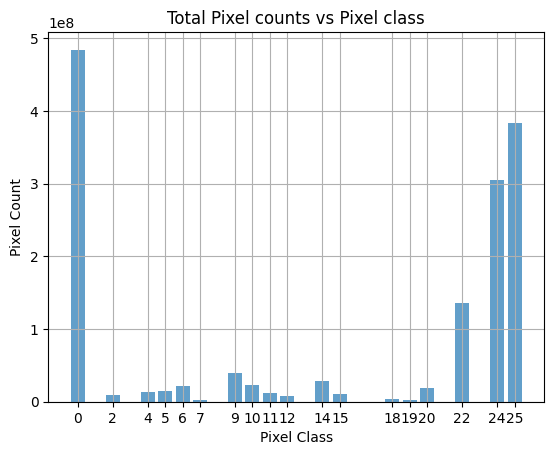

In [16]:
data_distri_viz(d)

Randomly select and display two images from the dataset along with their masks

In [17]:
rv = np.random.randint(1,len(d.img_files)+1,size=2)

i1 = cv2.imread(d.img_files[rv[0]])
i1 = cv2.resize(i1, (512, 512))

# Load and resize the first mask
mi1 = cv2.imread(d.mask_files[rv[0]], cv2.IMREAD_GRAYSCALE)
mi1 = cv2.resize(mi1, (512, 512))
m1 = np.array(mi1)

colored_mask1 = np.zeros((m1.shape[0], m1.shape[1], 3), dtype=np.uint8)
for class_id, color in color_mapping.items():
    colored_mask1[m1 == class_id] = color

# Load and resize the second image
i2 = cv2.imread(d.img_files[rv[1]])
i2 = cv2.resize(i2, (512, 512))

# Load and resize the second mask
mi2 = cv2.imread(d.mask_files[rv[1]], cv2.IMREAD_GRAYSCALE)
mi2 = cv2.resize(mi2, (512, 512))
m2 = np.array(mi2)

colored_mask2 = np.zeros((m2.shape[0], m2.shape[1], 3), dtype=np.uint8)
for class_id, color in color_mapping.items():
    colored_mask2[m2 == class_id] = color

# Display the first image and its segmentation
cv2.imshow("Image 1", i1)
cv2.imshow("Segmentation 1", colored_mask1)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Display the second image and its segmentation
cv2.imshow("Image 2", i2)
cv2.imshow("Segmentation 2", colored_mask2)
cv2.waitKey(0)
cv2.destroyAllWindows()

**Loading pretrained DeepLabV3+**

In [18]:
from network import modeling
from datasets import Cityscapes

In [19]:
model = modeling.__dict__['deeplabv3plus_mobilenet'](num_classes=19, output_stride=16)
model.load_state_dict( torch.load( "best_deeplabv3plus_mobilenet_cityscapes_os16.pth" )['model_state']  )


<All keys matched successfully>

In [21]:
dtest = dataloader(f_path,to_test=True)

In [22]:
batch_size = 1
test_data_loader = DataLoader(dtest, batch_size=batch_size, shuffle=False)

In [23]:
model = model.to(device)

In [24]:
transform2 = T.Compose([T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

'''
This transformation was used before sending the images to the model in the AutoNUE paper
'''

'\nThis transformation was used before sending the images to the model in the AutoNUE paper\n'

In [22]:
def bw_color_mapping(c_img) : 
    dummy_mask = np.ones((512, 512), dtype=np.uint8) * 255

    for key,value in color_mapping.items() :
        mask = np.all(c_img == value,axis=-1)
        np.putmask(dummy_mask, mask, key)
    
    return dummy_mask

In [23]:
test_indices = []
name_id_list = []

model = model.eval()

with torch.no_grad():
    for img in test_data_loader : 
        data_img, mask_img, idx = img

        print(f"{idx} | index : {idx[0]} | file name : {dtest.img_files[idx]}")

        test_indices.append(idx)

        data_img = transform2(data_img)
        
        data_img = data_img.to(device)
        pred = model(data_img).max(1)[1].cpu().numpy()[0]
        print(f"pred shape : {pred.shape}")
        # pred_np = np.array(pred)
        # print(np.unique(pred_np))
        

        colorized_preds = Cityscapes.decode_target(pred).astype('uint8')
        colorized_preds = Image.fromarray(colorized_preds)
        colorized_preds = np.array(colorized_preds)
        # print(f"cp : {colorized_preds.shape}")

        pred = bw_color_mapping(colorized_preds)
        pred_np = np.array(pred)
        print(np.unique(pred_np))


        name = dtest.img_files[idx]
        name_id = re.split('[_.]',name)[-2]
        name_id_list.append(name_id)

        path1_bw = os.path.join('val_predictions_bw',f'pred_mask_{name_id}_bw.jpg')
        path2 = os.path.join('val_predictions',f'pred_mask_{name_id}.jpg')

        cv2.imwrite(path1_bw,pred_np)

        cv2.imwrite(path2,colorized_preds)
        # colorized_preds.save(os.path.join('val_predictions',f'pred_mask_{idx[0]}.jpg'))



tensor([1933]) | index : 1933 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_2738.jpg
pred shape : (512, 512)
[ 0  4  5  6  9 10 11 14 15 18 19 20 22 24 25]
tensor([2484]) | index : 2484 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_3233.jpg
pred shape : (512, 512)
[ 0  4 10 14 18 22 24]
tensor([845]) | index : 845 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1759.jpg
pred shape : (512, 512)
[ 0  2  4  5  9 10 12 14 15 18 20 22 24 25]
tensor([5908]) | index : 5908 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_6315.jpg
pred shape : (512, 512)
[  0   2   4   5   7   9  10  11  12  14  15  18  20  22  24 255]
tensor([3244]) | index : 3244 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_3918.jpg
pred shape : (512, 512)
[  0   4   5   6   7   9  10  11  12  18  19  20  22  24 255]
tensor([3922]) | index : 3922 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_4528.jpg
pred shape : (512, 512)
[  0   2   4   5   6  10  15

In [24]:
name_id_list

['2752', '5367', '501', '196', '3725', '5450']

To visualize original image, original masks 

In [25]:
val_preds = sorted(glob.glob(os.path.join('val_predictions','*.jpg')))
val_preds_bw = sorted(glob.glob(os.path.join('val_predictions_bw','*.jpg')))
val_preds_bw

['val_predictions_bw\\pred_mask_196_bw.jpg',
 'val_predictions_bw\\pred_mask_2752_bw.jpg',
 'val_predictions_bw\\pred_mask_3725_bw.jpg',
 'val_predictions_bw\\pred_mask_501_bw.jpg',
 'val_predictions_bw\\pred_mask_5367_bw.jpg',
 'val_predictions_bw\\pred_mask_5450_bw.jpg']

In [26]:
all_pred_files = os.listdir('val_predictions')
all_pred_files

['pred_mask_196.jpg',
 'pred_mask_2752.jpg',
 'pred_mask_3725.jpg',
 'pred_mask_501.jpg',
 'pred_mask_5367.jpg',
 'pred_mask_5450.jpg']

In [27]:
p = dtest.img_files[test_indices[0].item()]
pres = re.split('[_.]',p)
pres[-2]

'2752'

In [28]:
for id in all_pred_files : 
    if pres[-2] in id : 
        print('found')
        print(id)

found
pred_mask_2752.jpg


In [29]:
val_predictions = [] 
val_predictions_bw = []

In [33]:
for i in range(len(test_indices)):

    img_id = re.split('[_.]',dtest.img_files[test_indices[i].item()])[-2]

    corresponding_val_pred = 'val_predictions'
    # corresponding_val_pred_bw = 'val_predictions_bw'
    
    for val_pred_file_name in all_pred_files : 
        if img_id in val_pred_file_name : 
            corresponding_val_pred = os.path.join(corresponding_val_pred,val_pred_file_name)
            # corresponding_val_pred_bw = os.path.join(corresponding_val_pred_bw,val_pred_file_name,)
            val_predictions.append(corresponding_val_pred)
            # val_predictions_bw.append(corresponding_val_pred_bw)

    
    print(corresponding_val_pred)


    i1 = cv2.imread(dtest.img_files[test_indices[i]])
    i1 = cv2.resize(i1, (512, 512))

    # Load and resize the first mask
    mi1 = cv2.imread(dtest.mask_files[test_indices[i]], cv2.IMREAD_GRAYSCALE)
    mi1 = cv2.resize(mi1, (512, 512))
    m1 = np.array(mi1)

    colored_mask1 = np.zeros((m1.shape[0], m1.shape[1], 3), dtype=np.uint8)
    for class_id, color in color_mapping.items():
        colored_mask1[m1 == class_id] = color


    p1 = cv2.imread(corresponding_val_pred)
    print(type(p1))
    p1 = cv2.resize(p1,(512,512))


    # Display the first image and its segmentation
    cv2.imshow("Image ", i1)
    cv2.imshow("Mask Label ", colored_mask1)
    cv2.imshow("Predicted Mask", p1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

val_predictions\pred_mask_2752.jpg
val_predictions\pred_mask_5367.jpg
val_predictions\pred_mask_501.jpg
val_predictions\pred_mask_196.jpg
val_predictions\pred_mask_3725.jpg
val_predictions\pred_mask_5450.jpg


Creating colored masks for all the files and saving it

In [34]:
masks = os.listdir('mask_archive')
for mask in masks : 
    print(mask)
    m = cv2.imread(f'mask_archive\{mask}',cv2.IMREAD_GRAYSCALE)
    m = cv2.resize(m,(512,512))
    m_arr = np.array(m)

    colored_mask = np.zeros((m.shape[0], m.shape[1], 3), dtype=np.uint8)
    for class_id, color in color_mapping.items():
        colored_mask[m == class_id] = color

    cv2.imwrite(f'mask_coloured_archive\{mask}.jpg',colored_mask)    

**Classwise performance**

1) Pixel Accuracy

In [35]:
pred_mask = []
og_mask = []

for i in name_id_list : 
    pmask = ''
    omask = ''

    for val_pred_mask_name in val_preds_bw : 
        if i in val_pred_mask_name : 
            pmask=val_pred_mask_name
    
    for og_mask_name in dtest.mask_files : 
        if i in og_mask_name:
            omask = og_mask_name
    
    # print(pmask)
    # print(omask)

    ip = cv2.imread(pmask,cv2.IMREAD_GRAYSCALE)
    ip = cv2.resize(ip,(512,512))
    parr = np.array(ip)

    pred_mask.append(parr)

    io = cv2.imread(omask,cv2.IMREAD_GRAYSCALE)
    io = cv2.resize(io,(512,512))
    oarr = np.array(io)

    og_mask.append(oarr)


In [36]:
pred_mask = np.stack(pred_mask)
og_mask = np.stack(og_mask)


In [37]:
classes =  [0,2,4,5,6,7,9,10,11,12,14,15,18,19,20,22,24,25]
class_dict = {key: 0 for key in classes}

In [38]:
# def accuracy(groundtruth_mask, pred_mask):
#     intersect = np.sum(pred_mask*groundtruth_mask)
#     union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
#     xor = np.sum(groundtruth_mask==pred_mask)
#     acc = np.mean(xor/(union + xor - intersect))
#     return round(acc, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    union = np.sum(np.subtract(np.add(pred_mask, groundtruth_mask), intersect))
    xor = np.sum(groundtruth_mask == pred_mask)
    acc = np.mean(xor / (union + xor - intersect))
    return round(acc, 3)


In [39]:
accuracy(pred_mask[0].flatten(),og_mask[0].flatten())

0.0

In [40]:
for i in range(len(pred_mask)) : 
    p_nparray = np.array(pred_mask[i]).flatten()
    o_nparray = np.array(og_mask[i]).flatten()
    for key in class_dict.keys() : 
        p = (p_nparray == key )
        # p = np.stack(p)
        o = (o_nparray == key )
        # p = np.stack(p)

        c_acc = np.sum(p == o)

        class_dict[key] += c_acc/len(pred_mask) * 100

In [41]:
p.sum()

1764

In [42]:
for key in class_dict : 
    print(f"{key} : {class_dict[key]}")

0 : 23214033.333333336
2 : 25827300.0
4 : 21670550.000000004
5 : 25812766.666666664
6 : 25775916.666666664
7 : 26101666.666666664
9 : 25946050.0
10 : 25889983.33333333
11 : 25259333.333333336
12 : 25245933.333333332
14 : 25584383.333333336
15 : 25728716.666666664
18 : 26139233.33333333
19 : 26149950.0
20 : 25844200.0
22 : 23202616.666666664
24 : 22528500.0
25 : 21181349.999999996


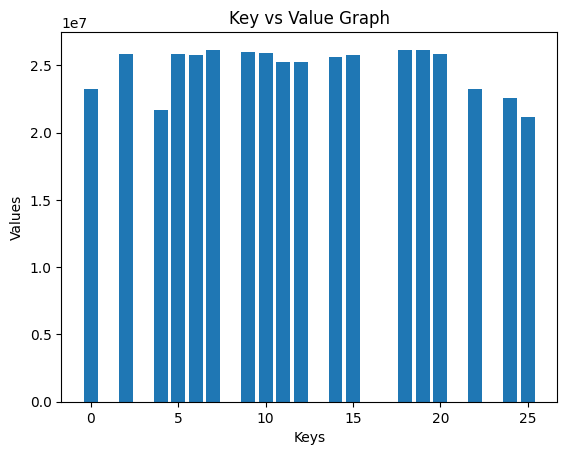

In [43]:
keys = class_dict.keys()
values = class_dict.values()
# Plotting
plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Key vs Value Graph')
plt.show()

Dice Coefficient

In [44]:
classes =  [0,2,4,5,6,7,9,10,11,12,14,15,18,19,20,22,24,25]
class_dict = {key: 0 for key in classes}

In [45]:
for i in range(len(pred_mask)) : 
    p_nparray = np.array(pred_mask[i]).flatten()
    o_nparray = np.array(og_mask[i]).flatten()
    
    for key in class_dict : 
        p = (p_nparray == key )
        o = (o_nparray == key )
        
        intersection = np.logical_and(o,p).sum()
        union = np.logical_or(o,p).sum()
        dice_coefficient = (2.0 * intersection) / (union + 1e-8)
        dice_coefficient = dice_coefficient 
        class_dict[key] += dice_coefficient/len(pred_mask)

In [46]:
for key in class_dict : 
    print(f"{key} : {class_dict[key]}")

0 : 1.3420439397144301
2 : 0.2359621467670518
4 : 0.0008169037721717699
5 : 0.03204439393690948
6 : 0.011982494289489233
7 : 0.0003921568627427913
9 : 0.023914150715903755
10 : 0.0
11 : 0.01157187000955718
12 : 0.0038617771837167526
14 : 0.0032151549206302257
15 : 0.1622008822342215
18 : 0.1947503553317755
19 : 0.002562227802966945
20 : 0.11358173401483336
22 : 0.5502404071123217
24 : 0.5083505013283939
25 : 0.011383167827465427


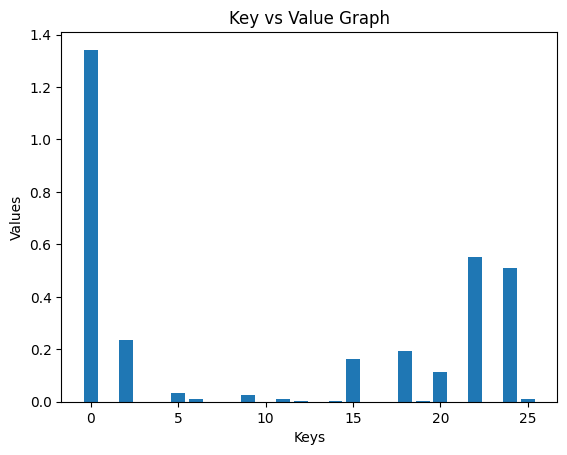

In [47]:
keys = class_dict.keys()
values = class_dict.values()
# Plotting
plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Key vs Value Graph')
plt.show()

IOU

In [48]:
classes =  [0,2,4,5,6,7,9,10,11,12,14,15,18,19,20,22,24,25]
class_dict = {key: 0 for key in classes}

In [49]:
for i in range(len(pred_mask)) : 
    p_nparray = np.array(pred_mask[i]).flatten()
    o_nparray = np.array(og_mask[i]).flatten()

    for key in class_dict : 
        p = (p_nparray == key )
        o = (o_nparray == key )
        
        intersection = np.logical_and(o,p).sum()
        # print(intersection)
        union = np.logical_or(o,p).sum()
        iou = intersection / (union + 1e-8)

        class_dict[key] += iou/len(pred_mask)


In [50]:
for key in class_dict : 
    print(f"{key} : {class_dict[key]}")

0 : 0.6710219698572151
2 : 0.1179810733835259
4 : 0.00040845188608588495
5 : 0.01602219696845474
6 : 0.005991247144744616
7 : 0.00019607843137139564
9 : 0.011957075357951878
10 : 0.0
11 : 0.00578593500477859
12 : 0.0019308885918583763
14 : 0.0016075774603151129
15 : 0.08110044111711075
18 : 0.09737517766588775
19 : 0.0012811139014834725
20 : 0.05679086700741668
22 : 0.27512020355616085
24 : 0.25417525066419694
25 : 0.005691583913732714


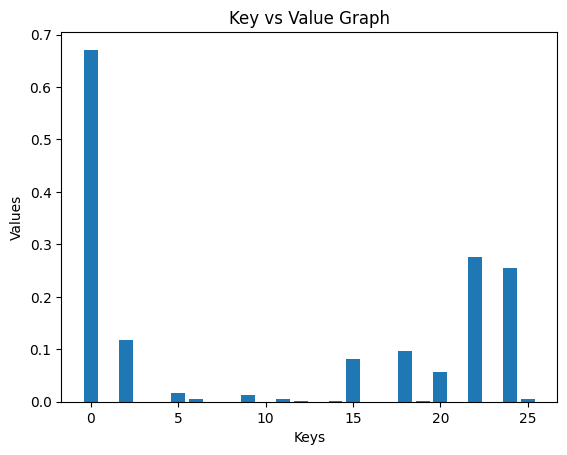

In [51]:
keys = class_dict.keys()
values = class_dict.values()
# Plotting
plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Key vs Value Graph')
plt.show()

Metrics ver 2.0

In [52]:
classes =  [0,2,4,5,6,7,9,10,11,12,14,15,18,19,20,22,24,25]
tp = {key: 0 for key in classes}
tn = {key: 0 for key in classes}
fp = {key: 0 for key in classes}
fn = {key: 0 for key in classes}

In [53]:
from tqdm import tqdm

In [54]:
for i in tqdm(range(len(pred_mask))):
    pred = pred_mask[i]
    act_mask = og_mask[i]

    pred = np.asarray(pred)
    pred.flatten()

    act_mask = np.asarray(act_mask)
    act_mask.flatten()

    for key in tp:
        tp[key] += sum((pred[act_mask == key] == key) == True)
        tn[key] += sum((pred[act_mask != key] != key) == True)
        fp[key] += sum((act_mask[pred == key] != key) == True)
        fn[key] += sum((pred[act_mask == key] != key) == True)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


In [55]:
tp[2]/(tp[2]+fn[2])

0.7157660167130919

In [56]:
tn

{0: 1035061,
 2: 1530366,
 4: 1300189,
 5: 1547709,
 6: 1546387,
 7: 1566098,
 9: 1556458,
 10: 1553399,
 11: 1514118,
 12: 1514727,
 14: 1535029,
 15: 1523803,
 18: 1567433,
 19: 1568994,
 20: 1550121,
 22: 1260443,
 24: 1220056,
 25: 1269646}

In [57]:
fp

{0: 90073,
 2: 15573,
 4: 268480,
 5: 17342,
 6: 14943,
 7: 6419,
 9: 9659,
 10: 19165,
 11: 2389,
 12: 47456,
 14: 33258,
 15: 28318,
 18: 3665,
 19: 3288,
 20: 15305,
 22: 84625,
 24: 161196,
 25: 18218}

In [58]:
fn

{0: 89949,
 2: 7653,
 4: 4151,
 5: 6756,
 6: 11366,
 7: 345,
 9: 6442,
 10: 300,
 11: 54915,
 12: 10652,
 14: 4543,
 15: 823,
 18: 845,
 19: 579,
 20: 6907,
 22: 96082,
 24: 59958,
 25: 283765}

Class wise pixel accuracy 

In [59]:
for key in tn.keys() : 
    print(f"accuracy for class {key} : {(tp[key]+tn[key])/(tp[key]+fn[key]+fp[key]+tn[key])}")

accuracy for class 0 : 0.8855450948079427
accuracy for class 2 : 0.9852333068847656
accuracy for class 4 : 0.8266658782958984
accuracy for class 5 : 0.9846789042154948
accuracy for class 6 : 0.9832731882731119
accuracy for class 7 : 0.9956995646158854
accuracy for class 9 : 0.9897632598876953
accuracy for class 10 : 0.9876244862874349
accuracy for class 11 : 0.9635670979817709
accuracy for class 12 : 0.9630559285481771
accuracy for class 14 : 0.9759667714436849
accuracy for class 15 : 0.9814726511637369
accuracy for class 18 : 0.9971326192220052
accuracy for class 19 : 0.9975414276123047
accuracy for class 20 : 0.9858779907226562
accuracy for class 22 : 0.8851095835367838
accuracy for class 24 : 0.8593940734863281
accuracy for class 25 : 0.8080043792724609


class wise precision 

In [60]:
for key in tn.keys() : 
    print(f"precision for class {key} : {(tp[key])/(tp[key]+fp[key])}")

precision for class 0 : 0.7988786524179755
precision for class 2 : 0.5530779164873009
precision for class 4 : 0.00016385872398742756
precision for class 5 : 0.05744877438991249
precision for class 6 : 0.011117728806829461
precision for class 7 : 0.0003114779629341224
precision for class 9 : 0.030610196708149337
precision for class 10 : 0.0
precision for class 11 : 0.3764030279300444
precision for class 12 : 0.0006107191744761503
precision for class 14 : 0.001021266370299171
precision for class 15 : 0.41295244413118287
precision for class 18 : 0.20082860880941997
precision for class 19 : 0.0009115770282588879
precision for class 20 : 0.03353119474614802
precision for class 22 : 0.6088315098063687
precision for class 24 : 0.44956120880997097
precision for class 25 : 0.06348635171952913


class wise recall 

In [61]:
for key in tn.keys() : 
    print(f"precision for class {key} : {(tp[key])/(tp[key]+fn[key])}")

precision for class 0 : 0.7990999039599759
precision for class 2 : 0.7157660167130919
precision for class 4 : 0.010488676996424315
precision for class 5 : 0.13528734161013695
precision for class 6 : 0.014565632044390498
precision for class 7 : 0.005763688760806916
precision for class 9 : 0.04520527641914925
precision for class 10 : 0.0
precision for class 11 : 0.025586883616941995
precision for class 12 : 0.002715101582248853
precision for class 14 : 0.007428446580729736
precision for class 15 : 0.9603239647109868
precision for class 18 : 0.5215175537938845
precision for class 19 : 0.005154639175257732
precision for class 20 : 0.07139015864479699
precision for class 22 : 0.5782103285395704
precision for class 24 : 0.6870864037742939
precision for class 25 : 0.004333333333333333


class wise iou 

In [62]:
for key in tn.keys() : 
    print(f"iou for class {key} : {(tp[key])/(tp[key]+fp[key]+fn[key])}")

iou for class 0 : 0.6652640465002985
iou for class 2 : 0.4534801637724128
iou for class 4 : 0.000161364261483451
iou for class 5 : 0.042019479228781555
iou for class 6 : 0.006345129735241908
iou for class 7 : 0.0002955956251847473
iou for class 9 : 0.01859075947823967
iou for class 10 : 0.0
iou for class 11 : 0.02454635209205733
iou for class 12 : 0.0004988217486282402
iou for class 14 : 0.0008986388264834148
iou for class 15 : 0.40602515236134606
iou for class 18 : 0.1695820290922482
iou for class 19 : 0.0007751937984496124
iou for class 20 : 0.02334784329244163
iou for class 22 : 0.42159137830043436
iou for class 24 : 0.3731604725516428
iou for class 25 : 0.0040729771979236065


confusion matrix 

In [83]:
import seaborn as sns 

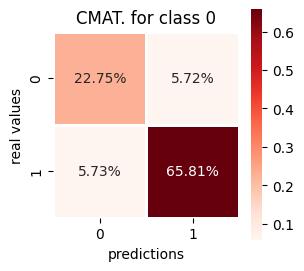

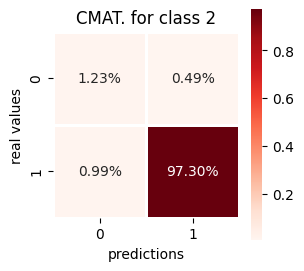

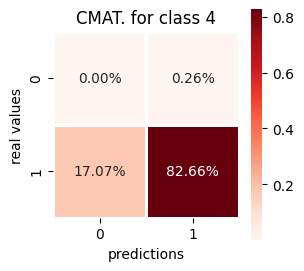

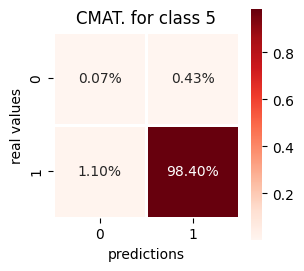

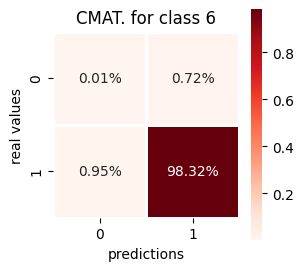

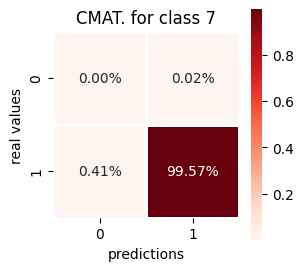

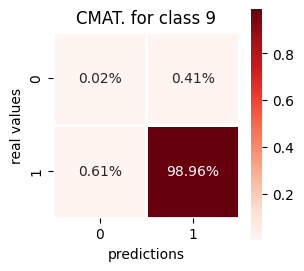

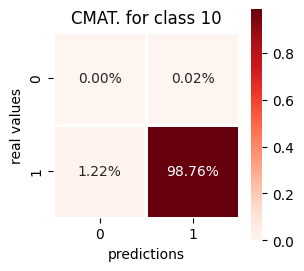

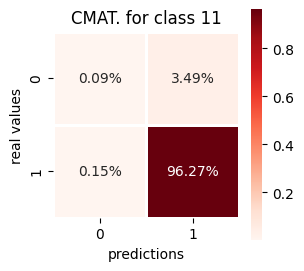

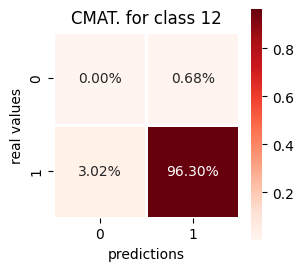

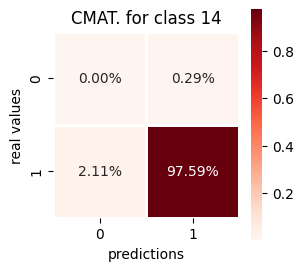

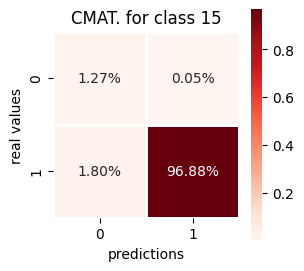

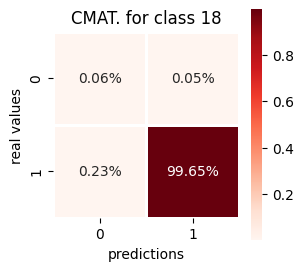

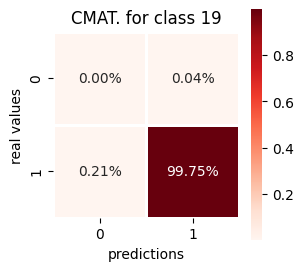

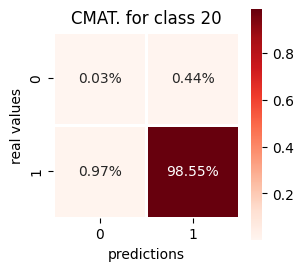

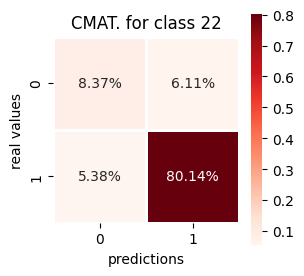

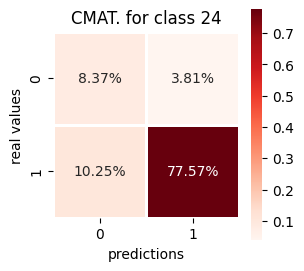

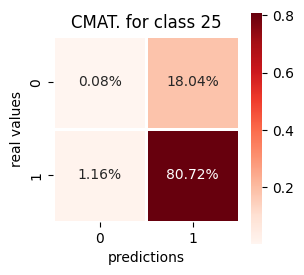

In [92]:
for key in tn.keys():
    cmat = [[tp[key], fn[key]], [fp[key], tn[key]]]
    plt.figure(figsize = (3,3))
    sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
    plt.title(f"CMAT. for class {key}")
    plt.xlabel("predictions")
    plt.ylabel("real values")
    plt.show()



On Cityscapes Val set

In [ ]:
im = 'cityscapes_val\1.jpg'

In [69]:
from PIL import Image
import numpy as np

# Load the image
img_path = 'cityscapes_val/1.jpg'  # Replace with the path to your 16-bit image
image = Image.open(img_path)

# Convert the image to a NumPy array
img_array = np.array(image)
# print(img_array.shape)

# Get the dimensions of the image
height, width = img_array.shape[:-1]

# Split the image in half horizontally
half_width = width // 2
img = img_array[:, :half_width]
mask = img_array[:, half_width:]

# Save the halves as new images
Image.fromarray(img).save('first_half.jpg')
Image.fromarray(mask).save('second_half.jpg')


In [72]:
city_val = os.listdir('cityscapes_val')
city_val

In [75]:
i = 1

for path in city_val : 
    img_path = path  # Replace with the path to your 16-bit image
    image = Image.open(f'cityscapes_val/{img_path}')

    # Convert the image to a NumPy array
    img_array = np.array(image)
    # print(img_array.shape)

    # Get the dimensions of the image
    height, width = img_array.shape[:-1]

    # Split the image in half horizontally
    half_width = width // 2
    img = img_array[:, :half_width]
    mask = img_array[:, half_width:]

    # Save the halves as new images
    Image.fromarray(img).save(f'cityscapes_final\image_archive\image_{i}.jpg')
    Image.fromarray(mask).save(f'cityscapes_final\mask_archive\mask_{i}.jpg')
    i += 1
    

In [78]:
dcity = dataloader('cityscapes_final')

In [79]:
city_val = DataLoader(dcity,batch_size=1,shuffle=True)

In [80]:
t = 0 
for batch in city_val : 
    img , mask , idx = batch 
    print(f"image shape : {img.shape} | mask shape : {mask.shape} | index : {idx}")
    t += 1 
    if(t==10):
        break 

image shape : torch.Size([1, 3, 512, 512]) | mask shape : torch.Size([1, 3, 512, 512]) | index : tensor([36], dtype=torch.int32)
image shape : torch.Size([1, 3, 512, 512]) | mask shape : torch.Size([1, 3, 512, 512]) | index : tensor([276], dtype=torch.int32)
image shape : torch.Size([1, 3, 512, 512]) | mask shape : torch.Size([1, 3, 512, 512]) | index : tensor([164], dtype=torch.int32)
image shape : torch.Size([1, 3, 512, 512]) | mask shape : torch.Size([1, 3, 512, 512]) | index : tensor([469], dtype=torch.int32)
image shape : torch.Size([1, 3, 512, 512]) | mask shape : torch.Size([1, 3, 512, 512]) | index : tensor([77], dtype=torch.int32)
image shape : torch.Size([1, 3, 512, 512]) | mask shape : torch.Size([1, 3, 512, 512]) | index : tensor([125], dtype=torch.int32)
image shape : torch.Size([1, 3, 512, 512]) | mask shape : torch.Size([1, 3, 512, 512]) | index : tensor([137], dtype=torch.int32)
image shape : torch.Size([1, 3, 512, 512]) | mask shape : torch.Size([1, 3, 512, 512]) | ind

In [87]:
test_indices = []
name_id_list = []

model = model.eval()

with torch.no_grad():
    for img in city_val : 
        data_img, mask_img, idx = img

        print(f"{idx} | index : {idx[0]} | file name : {dtest.img_files[idx]}")

        test_indices.append(idx)

        data_img = transform2(data_img)
        
        data_img = data_img.to(device)
        pred = model(data_img).max(1)[1].cpu().numpy()[0]
        print(f"pred shape : {pred.shape}")
        # pred_np = np.array(pred)
        # print(np.unique(pred_np))
        

        colorized_preds = Cityscapes.decode_target(pred).astype('uint8')
        colorized_preds = Image.fromarray(colorized_preds)
        colorized_preds = np.array(colorized_preds)
        # print(f"cp : {colorized_preds.shape}")

        pred = bw_color_mapping(colorized_preds)
        pred_np = np.array(pred)
        print(np.unique(pred_np))


        name = dtest.img_files[idx]
        name_id = re.split('[_.]',name)[-2]
        name_id_list.append(name_id)

        path1_bw = os.path.join('cityscapes_final\city_pred_bw',f'city_mask_{name_id}_bw.jpg')
        path2 = os.path.join('cityscapes_final\city_pred_color',f'city_mask_{name_id}.jpg')

        cv2.imwrite(path1_bw,pred_np)

        cv2.imwrite(path2,colorized_preds)
        # colorized_preds.save(os.path.join('val_predictions',f'pred_mask_{idx[0]}.jpg'))



tensor([321], dtype=torch.int32) | index : 321 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1287.jpg
pred shape : (512, 512)
[  0   2   4   5   7   9  10  14  15  20  22  24 255]
tensor([52], dtype=torch.int32) | index : 52 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1044.jpg
pred shape : (512, 512)
[  0   2   5  10  14  15  20  22  24 255]
tensor([76], dtype=torch.int32) | index : 76 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1066.jpg
pred shape : (512, 512)
[  0   2   5  15  20  22  24 255]
tensor([89], dtype=torch.int32) | index : 89 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_1078.jpg
pred shape : (512, 512)
[  0   2   5  10  14  15  20  22  24  25 255]
tensor([258], dtype=torch.int32) | index : 258 | file name : E:\Sem 6\CV\Assignment 1\image_archive\image_123.jpg
pred shape : (512, 512)
[  0   2   4   9  10  15  20  22  24 255]
tensor([469], dtype=torch.int32) | index : 469 | file name : E:\Sem 6\CV\Assignment 1\image_ar

KeyboardInterrupt: 